# Generative Modelling for Unsupervised Anomaly Detection on brain MRI

Tutorial for the AIM II course 

Date: 31.05.2023

Submission deadline: 15.06.2023

For questions please contact: cosmin.bercea@tum.de

## SETUP


### *Run these cells only when in Google Colab*

In [1]:
# # Clone the repository
# !git clone https://github.com/compai-lab/mad_seminar_s23.git
# # Move all content to the current directory
# !mv ./mad_seminar_s23/* ./
# # Remove the empty directory
# !rm -rf mad_seminar_s23/
# # Download the data
# !wget https://syncandshare.lrz.de/dl/fiH6r4B6WyzAaxZXTEAYCE/data.zip -P ./data/
# # Extract the data
#!unzip -q ./data/data.zip -d ./data/

--2023-05-31 10:32:53--  https://syncandshare.lrz.de/dl/fiH6r4B6WyzAaxZXTEAYCE/data.zip
Resolving syncandshare.lrz.de (syncandshare.lrz.de)... 129.187.255.213
Connecting to syncandshare.lrz.de (syncandshare.lrz.de)|129.187.255.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40922332 (39M) [application/x-zip-compressed]
Saving to: ‘./data/data.zip’

data.zip            100%[===================>]  39,03M  12,5MB/s    in 3,1s    

2023-05-31 10:32:56 (12,5 MB/s) - ‘./data/data.zip’ saved [40922332/40922332]



In [2]:
#!pip install pytorch_lightning --quiet

ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [3]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import AutoencoderModel
from data_loader import TrainDataModule, get_all_test_dataloaders

# autoreload imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the config

In [43]:
with open('./configs/train_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Global seed set to 3105


3105

## Data (IXI and FastMRI+) 

### Load and visualize the *healthy* data

Found 582 files in ./data/IXI
Using 465 images for training and 117 images for validation
Batch shape: torch.Size([32, 1, 128, 128])
Batch min: 0.0
Batch max: 1.0


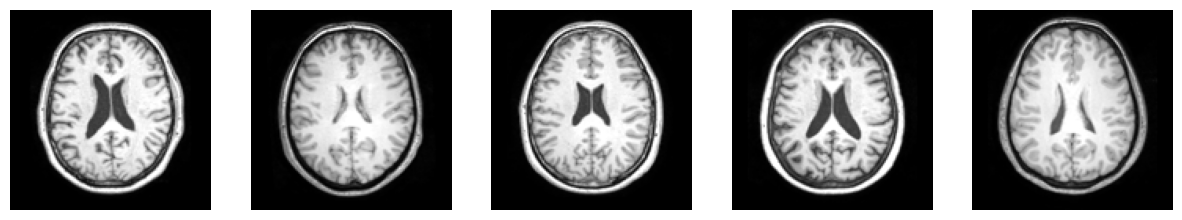

In [4]:
train_data_module = TrainDataModule(
    data_dir=config['train_data_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

### Load and visualize the *anomalous* data

In [42]:
## Load and visualize anomalous data with labels 
# Get test dataloaders
test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])
print(f'Disese types: {test_dataloaders.keys()}')
diseases = ['absent_septum', 'edema', 'enlarged_ventricles', 'mass', 'dural', 'lesions', 'resection']
fig, ax = plt.subplots(3, len(diseases), figsize=(15, 5))
for i in range(len(diseases)):
  batch = next(iter(test_dataloaders[diseases[i]]))
  inputs, pos_labels, neg_masks = batch
  ax[0][i].imshow(inputs[i].squeeze(), cmap='gray')
  ax[0][i].axis('off')
  ax[1][i].imshow(pos_labels[i].squeeze(), cmap='gray')
  ax[1][i].axis('off')
  ax[2][i].imshow(neg_masks[i].squeeze(), cmap='gray')
  ax[2][i].axis('off')
  ax[0][i].set_title(diseases[i])

NameError: name 'config' is not defined

# Generative Modelling 

In [10]:
from IPython.display import Image, display, Markdown
display(Markdown("## Auto-encoders (AEs)"))
display(Markdown("### In a nutshell: "))
display(Markdown("- AEs learn a compact representation of a data distribution, called the *latent space* or *bottleneck*"))
display(Markdown("- For example, if we train an AE on images of chest X-rays, we expect them to learn how to describe a healthy chest X-ray with meaningulf featurs, such as the *shape and size fo the lungs*, *intensity of the image*, *number of ribs*, *shape of the heart*, etc..."))

Image(url='./ae.gif')

## Auto-encoders (AEs)

### In a nutshell: 

- AEs learn a compact representation of a data distribution, called the *latent space* or *bottleneck*

- For example, if we train an AE on images of chest X-rays, we expect them to learn how to describe a healthy chest X-ray with meaningulf featurs, such as the *shape and size fo the lungs*, *intensity of the image*, *number of ribs*, *shape of the heart*, etc...

In [11]:
display(Markdown("### Unsupervised Anomaly Detection"))

display(Markdown("The main assumption of unsupervised anomaly detection is that AEs can then only reconstruct what they have been trained on"))

display(Markdown("- Anomalies are thus detected based on *residual errors* between input and reconstruction"))

Image(url='./angelina.gif')

### Unsupervised Anomaly Detection

The main assumption of unsupervised anomaly detection is that AEs can then only reconstruct what they have been trained on

- Anomalies are thus detected based on *residual errors* between input and reconstruction

### ** Q1: ** Are AEs generative models? Why / Why not?  

### ** Q2: ** What does it take to turn AEs into generative models? 

### **T1:** We have prepared an autoencoder model ready for you to train, check the model folder for more details.

- T1A: Implement evaluate_healthy() function from evaluate.py script. For the evaluation of the model on the healthy data you have to implement the evaluate_healthy function from the evaluate.py script. You can take inspiration from the evluate function that is already implemented
- T2B: Please train the model with the following scripts, evaluate the results and answer the questions.  

**Q3:** How does the model perform in terms of reconstruction accuarcy on the healthy images?

**Q4:** How does the model perform in anomlay detection? What diseases are easy to detect, what diseases are more diffucult? Why? 


## Tensorboard

In [12]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Prepare model

In [16]:
# Init model
model = AutoencoderModel(config)

# Use tensorboard logger and CSV logger
trainer = pl.Trainer(
    max_epochs=config['num_epochs'],
    logger=[
        pl.loggers.TensorBoardLogger(save_dir='./'),
        pl.loggers.CSVLogger(save_dir='./')
    ],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Run training

In [17]:
# Train the model
trainer.fit(model, datamodule=train_data_module)

Missing logger folder: ./lightning_logs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 388 K 
1 | decoder | Sequential | 388 K 
2 | loss_fn | MSELoss    | 0     
---------------------------------------
776 K     Trainable params
0         Non-trainable params
776 K     Total params
3.105     Total estimated model params size (MB)


{'seed': 3105, 'train_data_dir': './data/IXI', 'split_dir': './data/splits', 'target_size': [128, 128], 'batch_size': 32, 'num_epochs': 20, 'lr': 0.001}


/opt/anaconda3/envs/aim/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory ./lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/aim/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/aim/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/aim/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_e

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Evaluation

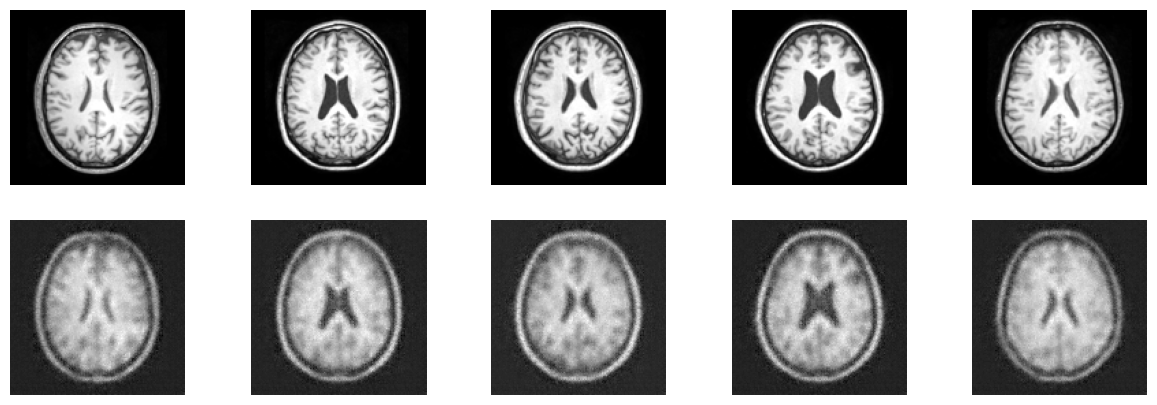

In [18]:
# Reconstructions from the validation set
batch = next(iter(train_data_module.val_dataloader()))

with torch.inference_mode():
    results = model.detect_anomaly(batch)
    reconstructions = results['reconstruction']

# Plot images and reconstructions
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0][i].imshow(batch[i].squeeze(), cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(reconstructions[i].squeeze(), cmap='gray')
    ax[1][i].axis('off')

### Evalute anomaly detection

In [23]:
from evaluate import Evaluator 

evaluator = Evaluator(model, model.device, test_dataloaders)

metrics, fig_metrics, fig_example = evaluator.evaluate()

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [on]
Loading model from: /opt/anaconda3/envs/aim/lib/python3.9/site-packages/lpips/weights/v0.1/squeeze.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/envs/aim/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/anaconda3/envs/aim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.

/opt/anaconda3/envs/aim/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-t

Loading model from: /opt/anaconda3/envs/aim/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
*********************** DATASET: absent_septum ********************
L1 mean: 0.12279718369245529 +/- 0.0
LPIPS mean: 0.46993446350097656 +/- 0.0
SSIM mean: 0.37424607365805906 +/- 0.0
TP mean: 1.0 +/- 0.0
TP: 1 of 1 detected
FP mean: 70.0 +/- 0.0
FP: 70 missed
Precision mean: 0.014084507042253521 +/- 0.0
Recall mean: 1.0 +/- 0.0
F1 mean: 0.02777777750385803 +/- 0.0
*********************** DATASET: artefacts ********************
L1 mean: 0.10389226116240025 +/- 0.012380215134724683
LPIPS mean: 0.4089268445968628 +/- 0.03379145637154579
SSIM mean: 0.3129025460966865 +/- 0.03158273040673951
TP mean: 1.0 +/- 0.0
TP: 16 of 16 detected
FP mean: 61.0625 +/- 62.55044838967983
FP: 977 missed
Precision mean: 0.05218929831734907 +/- 0.05747954004038087
Recall mean: 1.0 +/- 0.0
F1 mean: 0.09389767248850825 +/- 0.09718813914325425
*********************** DATASET: craniatomy ********************
L1 me

/Users/cosmin.bercea/workspace/tum/aim_generative_practical/evaluate.py:148: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



L1 mean: 0.11286204266879293 +/- 0.007669783404652992
LPIPS mean: 0.4294550120830536 +/- 0.03466358780860901
SSIM mean: 0.3136416676204863 +/- 0.02844310625545976
TP mean: 1.0 +/- 0.0
TP: 18 of 18 detected
FP mean: 16.833333333333332 +/- 13.363507523600733
FP: 303 missed
Precision mean: 0.09007199526273194 +/- 0.05451647688867019
Recall mean: 1.0 +/- 0.0
F1 mean: 0.16074868526012207 +/- 0.09026385898497098
*********************** DATASET: encephalomalacia ********************
L1 mean: 0.10912972688674927 +/- 0.0
LPIPS mean: 0.40892255306243896 +/- 0.0
SSIM mean: 0.3180915521010906 +/- 0.0
TP mean: 1.0 +/- 0.0
TP: 1 of 1 detected
FP mean: 14.0 +/- 0.0
FP: 14 missed
Precision mean: 0.06666666666666667 +/- 0.0
Recall mean: 1.0 +/- 0.0
F1 mean: 0.12499999882812501 +/- 0.0
*********************** DATASET: enlarged_ventricles ********************
L1 mean: 0.11211123395907252 +/- 0.011127352260623039
LPIPS mean: 0.4341091811656952 +/- 0.04095282778143883
SSIM mean: 0.2997653462749291 +/- 0.05

In [36]:
print(f'Available metrics: {fig_metrics.keys()}')
fig_metrics['F1']

Available metrics: dict_keys(['L1', 'LPIPS', 'SSIM', 'TP', 'FP', 'Precision', 'Recall', 'F1'])


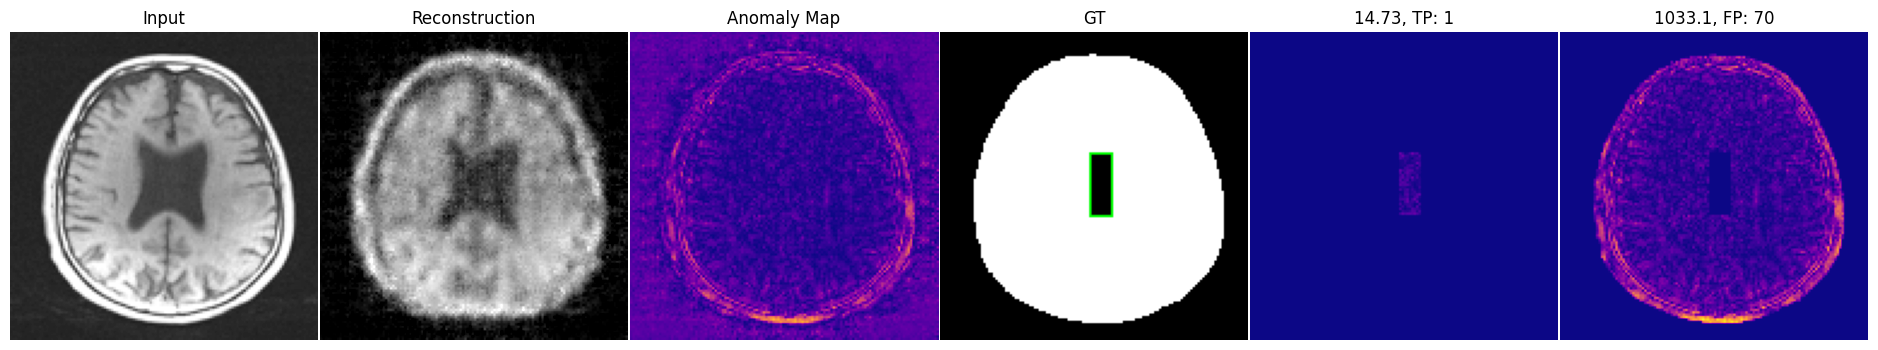

In [27]:
fig_example


## ***** T2 *****: Generative AEs 

- ***** **T2a** *****: Extend to provided AE to be a generative model (There is not a single solution!)

- ***** **Q5:** ***** Train and evaluate your generative AE. How does it compare to the AE we provided? 

In [38]:
display(Markdown("## Diffusion Models"))
display(Markdown("### In a nutshell: "))
display(Markdown("- Learn how to noise and de-noise an image"))
display(Markdown("- Noise granularity (e.g., noise level t) or noise type (e.g. Gaussian or Simplex) can vary"))


Image(url='./diff.gif')

## Diffusion Models

### In a nutshell: 

- Learn how to noise and de-noise an image

- Noise granularity (e.g., noise level t) or noise type (e.g. Gaussian or Simplex) can vary

In [39]:
display(Markdown("### Anomaly Detection with Diffusion Models"))
display(Markdown("- Destory te structure of anomalies and reconstruct pseudo-healthy images."))


### Anomaly Detection with Diffusion Models

- Destory te structure of anomalies and reconstruct pseudo-healthy images.

## Q5: Why are diffusion probalistic models considered to be generative models? 

## ***** T3 *****: Evaluate diffusion models 
- ***** **T3a** *****: Load and evaluate diffuson models on the same task as before (t=200). 
- ***** **Q6: ***** How does it compare to AEs? 
- T3b: Evaluate diffusion with different time-steps (t), what do you notice? Find a case for which a noise level works good and one where it doesn't. Why do you think this happened? 

### Load weights 

In [4]:
#!wget https://syncandshare.lrz.de/dl/fiGC15qSsdj1Tx7uojZvAT/latest_model.pt.zip
!unzip -q latest_model.pt.zip 

replace latest_model.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [28]:
with open('./configs/diffusion_config.yaml', 'r') as f:
    diff_config = yaml.safe_load(f)

In [29]:
from model.ddpm import DDPM

In [38]:
diff_config['train_scheduler'] = 'ddpm'
diff_config['inference_scheduler'] = 'ddpm'
diff_config['inference_steps'] = 1000

In [37]:
diff_config

{'spatial_dims': 2,
 'in_channels': 1,
 'out_channels': 1,
 'num_channels': [128, 256, 256],
 'attention_levels': [False, True, True],
 'num_res_blocks': 1,
 'num_head_channels': 256,
 'train_scheduler': 'ddpm',
 'inference_scheduler': 'ddpm',
 'inference_steps': 200,
 'noise_level': 300,
 'noise_type': 'gaussian',
 'prediction_type': 'epsilon'}

In [39]:
diff_config
anoddpm = DDPM(**diff_config)

In [45]:
test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])
print(f'Disese types: {test_dataloaders.keys()}')
batch = next(iter(test_dataloaders['edema']))[0]

Disese types: dict_keys(['absent_septum', 'artefacts', 'craniatomy', 'dural', 'ea_mass', 'edema', 'encephalomalacia', 'enlarged_ventricles', 'intraventricular', 'lesions', 'mass', 'posttreatment', 'resection', 'sinus', 'wml', 'other'])


tensor([[[[0.1804, 0.1529, 0.1882,  ..., 0.1765, 0.1647, 0.1529],
          [0.1725, 0.1569, 0.1529,  ..., 0.1490, 0.1569, 0.1529],
          [0.1647, 0.1647, 0.1804,  ..., 0.1608, 0.1490, 0.1725],
          ...,
          [0.1608, 0.1647, 0.1725,  ..., 0.1451, 0.1569, 0.1647],
          [0.1529, 0.1529, 0.1608,  ..., 0.1529, 0.1490, 0.1529],
          [0.1529, 0.1529, 0.1412,  ..., 0.1529, 0.1490, 0.1451]]],


        [[[0.1647, 0.1490, 0.1490,  ..., 0.1412, 0.1412, 0.1333],
          [0.1647, 0.1333, 0.1373,  ..., 0.1412, 0.1490, 0.1451],
          [0.1529, 0.1529, 0.1451,  ..., 0.1529, 0.1804, 0.1490],
          ...,
          [0.1490, 0.1412, 0.1373,  ..., 0.1490, 0.1529, 0.1255],
          [0.1373, 0.1333, 0.1490,  ..., 0.1373, 0.1529, 0.1490],
          [0.1529, 0.1451, 0.1373,  ..., 0.1490, 0.1608, 0.1490]]],


        [[[0.1216, 0.1333, 0.1255,  ..., 0.1294, 0.1137, 0.1137],
          [0.1216, 0.1333, 0.1176,  ..., 0.1176, 0.1216, 0.1255],
          [0.1255, 0.1216, 0.1137,  ..

In [ ]:
t=50
x_, _ = anoddpm.sample_from_image(batch, noise_level=t)

 10%|█████████████▉                                                                                                                                | 5/51 [01:21<12:45, 16.63s/it]